# Deep Learning and Neural Networks

# Assignment 1

## 1 Analyze distances between images

In [1]:
#Start: 17:20 >60min
# load libraries
import pandas as pd
import numpy as np

from sklearn.metrics import pairwise_distances, confusion_matrix, mean_squared_error
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.special import softmax
from itertools import combinations

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time

In [2]:
# import the data
train_in_df = pd.read_csv('data/train_in.csv', header = None)
train_out_df = pd.read_csv('data/train_out.csv', names = ["Label"])
test_in_df = pd.read_csv('data/test_in.csv', header = None)
test_out_df = pd.read_csv('data/test_out.csv', names = ["Label"])
train_df = pd.concat([train_in_df, train_out_df], axis = 1)

In [3]:
# calculate the centers
centers = train_df.groupby("Label").mean()

# calculate the radius
## using scipy.spatial.distance.cdist and list comprehesion 
## takes each center from centers and calculates distance to associated Cloud C_d from train_in
radius = [max(cdist(centers[:i+1], train_in_df.loc[train_df["Label"]== i])[0]) for i in range(10)]
radius = pd.Series(radius, name = "Radius").round(decimals = 4)

# calculate the number of points of C_d
n = pd.Series(train_df.groupby("Label").count()[0], name = "Count")

# show the data
pd.concat([radius, n], axis = 1)

,Radius,Count
0,15.8929,319
1,15.8055,252
2,16.7543,202
3,16.4134,131
4,16.2300,122
5,15.7010,88
6,15.2586,151
7,16.3446,166
8,15.5925,144
9,16.4174,132


In [4]:
# calculate pairwise distances
pd.DataFrame(squareform(pdist(centers, 'euclidean')))

,0,1,2,3,4,5,6,7,8,9
0,0.000000,14.449608,9.334556,9.143734,10.769844,7.519296,8.154443,11.864555,9.907902,11.488875
1,14.449608,0.000000,10.125323,11.733233,10.173786,11.118800,10.614700,10.743154,10.086777,9.932094
2,9.334556,10.125323,0.000000,8.178285,7.932541,7.906796,7.331808,8.872531,7.077516,8.887748
3,9.143734,11.733233,8.178285,0.000000,9.087608,6.118750,9.302065,8.922401,7.020425,8.354350
4,10.769844,10.173786,7.932541,9.087608,0.000000,8.001517,8.782233,7.583012,7.380909,6.010408
5,7.519296,11.118800,7.906796,6.118750,8.001517,0.000000,6.698692,9.211954,6.967386,8.258538
6,8.154443,10.614700,7.331808,9.302065,8.782233,6.698692,0.000000,10.888237,8.587222,10.440004
7,11.864555,10.743154,8.872531,8.922401,7.583012,9.211954,10.888237,0.000000,8.467785,5.426474
8,9.907902,10.086777,7.077516,7.020425,7.380909,6.967386,8.587222,8.467785,0.000000,6.401166
9,11.488875,9.932094,8.887748,8.354350,6.010408,8.258538,10.440004,5.426474,6.401166,0.000000


## 2 Implement and evaluate the simpliest classifier


In [5]:
train_preds = list(pairwise_distances(train_in_df, centers).argmin(axis = 1))
train_acc = sum(train_out_df.iloc[:,0] == train_preds)/len(train_in_df)

test_preds = list(pairwise_distances(test_in_df, centers).argmin(axis = 1))
test_acc = sum(test_out_df.iloc[:,0] == test_preds)/len(test_in_df)

print("Training Accuracy {}".format(train_acc))
print("Test Accuracy {}".format(test_acc))

Training Accuracy 0.8635032220269478
Test Accuracy 0.804


### 2.1 Apply simple_classifier to training set

In [6]:
# create confusion matrix
cm_train = confusion_matrix(train_out_df, train_preds).astype(int)
cm_test = confusion_matrix(test_out_df, test_preds)

### 2.2 Rerun the code using alternative distance measures

In [7]:
# create list of distance measurments
#Question: is our center computed with Euclidean distance in mind?!
metrics = ["cosine", "euclidean", "l1", "mahalanobis", "chebyshev"]
train_acc_list = []
test_acc_list = []

for metric in metrics:
    train_preds = list(pairwise_distances(train_in_df, centers, metric = metric).argmin(axis = 1))
    train_acc = sum(train_out_df.iloc[:,0] == train_preds)/len(train_in_df)
    
    test_preds = list(pairwise_distances(test_in_df, centers, metric = metric).argmin(axis = 1))
    test_acc = sum(test_out_df.iloc[:,0] == test_preds)/len(test_in_df)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
pd.DataFrame([train_acc_list, test_acc_list], columns = metrics, index = ["train", "test"])

,cosine,euclidean,l1,mahalanobis,chebyshev
train,0.860574,0.863503,0.765671,0.96075,0.842414
test,0.799000,0.804000,0.721000,0.72100,0.784000


## 3 Implement a multi-class perceptron algorithm

### 3.1 Implementation of multi-class perceptron algorithm from slide 36

In [6]:
class MC_Perceptron:
    """Multilayer Perceptron Class"""
    def __init__(self, max_epochs = 100):
        """init method that takes number of epochs as input, defaults to 100."""
        self.max_epochs = max_epochs

    def fit_model(self, X, y):
        """Train the Multi-Class Perceptron algorithm 
    
        Each epoch of training, the dot product between the weights and each input vector is taken.
        For a misclassified example, the weigths of the corresponding nodes which are activated more then 
        the true node are updated by subtracting the input vector. The weights of the true node of a 
        misclassified example are updated by adding the input vector. The weights of all other nodes are 
        left unchanged. If there are no more misclassified examples, the iterative algorithm stops and 
        the final weight vector should be stable.
    
        input:
        features = training data, array like
        labels = training labels, array like
    
        output:
        errors = list of misclassified examples per epoch
        epoch = number of epochs until convergence
        weights = final weights, array like
        """
        # initialize features + bias, adds vector as first column
        inputs = np.hstack((np.ones((X.shape[0], 1)), X))
    
        # initialize weights randomly with mean 0 and range [-1, 1]
        # 2 for scaling of uniform distribution, -1 for shift
        weights = 2 * np.random.random_sample((X.shape[1] + 1, 10)) - 1
    
        # initialize variables
        N = len(X)
        errors = []
        epoch = 0
    
        # calculate outputs and update weights     
        while epoch < self.max_epochs:
            errors_count = 0
            for i in range(N):
                outputs = softmax(np.dot(inputs[i], weights)) #computes softmax of dotproduct 
                actual_cat = int(y[i])
                actual_val = outputs[actual_cat]              #values of output layer for real class
                pred = np.argmax(outputs)                     #prediction is maximum value of output vector
                if pred != actual_cat:
                    errors_count += 1
                    over_activated = outputs > actual_val     #creates boolean index
                    weights[:,over_activated] = np.subtract(weights[:,over_activated].T, inputs[i]).T #subtracts x from weights
                    weights[:,actual_cat] += inputs[i]
            errors.append(errors_count)        
            epoch += 1
            
            #leave loop if all classifications are correct
            if errors[epoch-1] == 0:
                break
        
        self.fitted_weights = weights
        self.epoch_fitting = epoch
        self.errors_fitting = errors
        return None

    def predict(self, X):
        """
        Uses fitted weights to predict labels of X
        input: X
        output: Predictions
        """
        # features + bias
        inputs = np.hstack((np.ones((X.shape[0], 1)), X))

        # calculate predictions
        preds = np.argmax(np.dot(inputs, self.fitted_weights), axis = 1)
    
        return preds


In [7]:
# convert data into numpy arrays
train_in = np.array(train_in_df)
train_out = np.array(train_out_df)
test_in = np.array(test_in_df)
test_out = np.array(test_out_df)

## 3.2 Implementation of multi-class perceptron algorithm from Géron's Textbook



In [8]:
class MC_Perceptron_modified(object):

    def __init__(self, lr = 1, max_epochs = 100):
        self.lr = lr
        self.max_epochs = max_epochs
    
    def fit_model(self, X, y):
        """
        Train the Multi-Class Perceptron algorithm 

        Each epoch of training, the dot product between the weights and each input vector is taken.
        The Perceptron is fed one training instance at a time, and for each instance it makes its predictions.

        input:
        X = training data, array like
        y = training labels, array like

        output:
        errors = list of misclassified examples per epoch
        epoch = number of epochs until convergence
        weights = final weights, array like
        """
        # features + bias
        inputs = np.hstack((np.ones((X.shape[0], 1)), X))

        # initialize weights randomly with mean 0 and range [-1, 1]
        weights = 2 * np.random.random_sample((X.shape[1] + 1, 10)) - 1

        # initialize variables
        N = len(X)
        errors = []
        epoch = 0

        # calculate outputs and update weights     
        while epoch < self.max_epochs:
            errors_count = 0
            for i in range(N):
                xi = np.resize(inputs[i], (257,1))
                outputs = np.dot(weights.T, xi)
                pred = np.argmax(outputs)
                actual = int(y[i])
                if pred != actual:
                    errors_count += 1
                    pred_vec = softmax(outputs)
                    true_vec = np.zeros((1,10)).T
                    true_vec[int(y[i])] = 1
                    difference = true_vec - pred_vec
                    delta = self.lr * np.dot(difference, xi.T) 
                    weights += delta.T
            errors.append(errors_count)
            epoch += 1
            if errors[epoch-1] == 0:
                break
        
        self.fitted_weights = weights
        self.epoch_fitting = epoch
        self.errors_fitting = errors
        return None
        
    def predict(self, X):
        """
        Classify the input features using the trained weights. 
        input:
        X = array of image vectors
        self.weights_fitted = vector of fitted weights from train_weights()

        output:
        pred = array of predicted classes
        """
        # features + bias
        inputs = np.hstack((np.ones((X.shape[0], 1)), X))

        # calculate predictions
        preds = np.argmax(np.dot(inputs, self.fitted_weights), axis = 1)
 
        return preds

In [9]:
#Evaluate both Perceptrons by running them multiple times

#Lists for First Model
epochs_list_1 = []
accuracy_list_1 = []
errors_arr_1 = []
time_list_1 = []

#Lists for Second Model
epochs_list_2 = []
accuracy_list_2 = []
errors_arr_2 = []
time_list_2 = []

for _ in range(50): #set number of iterations
        #First Model
        MC_temp = MC_Perceptron()
        pre = time.time()
        MC_temp.fit_model(train_in, train_out)
        time_list_1.append(time.time() - pre)
        preds = MC_temp.predict(test_in)
        accuracy = np.sum(preds == test_out[:,0])/len(test_out)
        epochs_list_1.append(MC_temp.epoch_fitting)
        accuracy_list_1.append(accuracy) 
        errors_arr_1.append(np.array(MC_temp.errors_fitting))

        #Second Model
        MC_temp = MC_Perceptron_modified()
        pre = time.time()
        MC_temp.fit_model(train_in, train_out)
        time_list_2.append(time.time() - pre) #appends time after fitting
        preds = MC_temp.predict(test_in)
        accuracy = np.sum(preds == test_out[:,0])/len(test_out)
        epochs_list_2.append(MC_temp.epoch_fitting)
        accuracy_list_2.append(accuracy)
        errors_arr_2.append(np.array(MC_temp.errors_fitting))

In [14]:
#pad errors lists with 0's at end so that all have same length
padded_arr_list = []
for errors_arr in [errors_arr_1, errors_arr_2]:
    max_length = 70
    padded_list = []
    for l in errors_arr:
        padded_list.append(np.pad(l, (0, max_length - len(l)), mode = "edge" )) 
    padded_arr_list.append(np.vstack(padded_list))

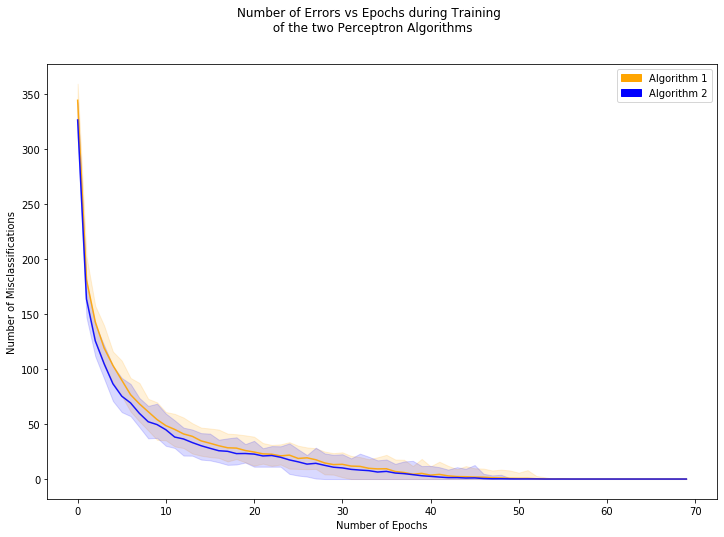

In [15]:
##Plot the lines for both algorithms
fig, ax = plt.subplots(1,1, figsize = (12,8))
colours = ["orange", "blue"]
#Create patches for legend
orange_patch = mpatches.Patch(color='orange', label='Algorithm 1')
blue_patch = mpatches.Patch(color='blue', label='Algorithm 2')
#loop for two different algorithms
for i in range(2):
    padded_arr = padded_arr_list[i]
    max_err = np.quantile(padded_arr, 0.975, axis = 0) 
    min_err = np.quantile(padded_arr, 0.025, axis = 0)
    ax.fill_between(range(max_length), max_err, min_err,
                                  alpha = 0.15,
                                  color = colours[i])
    ax.plot(range(max_length), np.mean(padded_arr.T, axis = 1), color = colours[i], alpha = 0.9)
    ax.set_ylabel('Number of Misclassifications')
    ax.set_xlabel('Number of Epochs')
    ax.legend(handles = [orange_patch, blue_patch])

fig.suptitle("Number of Errors vs Epochs during Training \n of the two Perceptron Algorithms")
#plt.savefig("ErrorsVEpochs3.png")
plt.show()

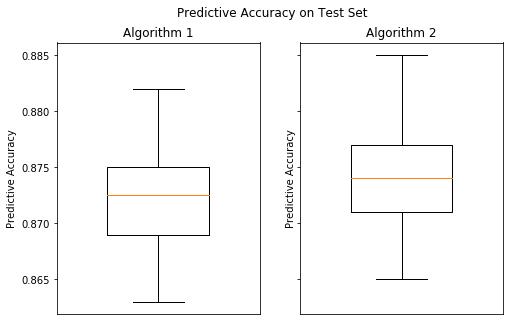

In [16]:
#Plot Predictive Accuracy Boxplots of both algorithms
fig, axes = plt.subplots(1,2, figsize = (8,5), sharey=True)
names = ["Algorithm 1", "Algorithm 2"]
accuracy_lists = [accuracy_list_1, accuracy_list_2]
for i in range(2):
    accuracy_list = accuracy_lists[i]
    axes[i].boxplot(accuracy_list, widths = 0.5)
    axes[i].set_title(names[i])
    axes[i].set_ylabel("Predictive Accuracy")
    axes[i].set_xticks([], [])
      
fig.suptitle("Predictive Accuracy on Test Set")
#plt.savefig("BP3_Accuracy.png")
plt.show()

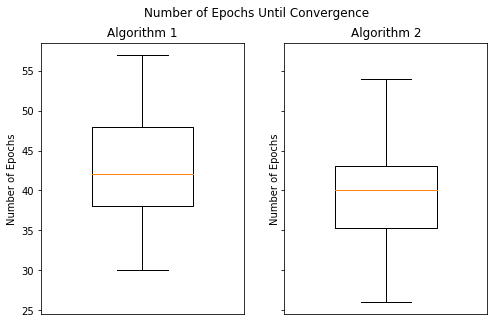

In [17]:
#Plot Epochs boxplots of both algorithms
fig, axes = plt.subplots(1,2, figsize = (8, 5), sharey=True)
epoch_lists = [epochs_list_1, epochs_list_2]
for i in range(2):
    epoch_list = epoch_lists[i]
    axes[i].boxplot(epoch_list, widths = 0.5)
    axes[i].set_title(names[i])
    axes[i].set_ylabel("Number of Epochs")
    axes[i].set_xticks([], [])
fig.suptitle("Number of Epochs Until Convergence")
#plt.savefig("BP3_Epochs.png")
plt.show()

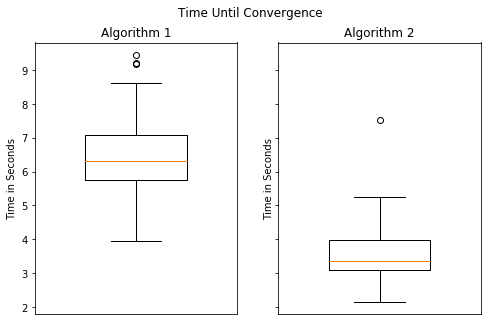

In [18]:
#Plot Times of both algorithms
fig, axes = plt.subplots(1,2, figsize = (8,5), sharey=True)
time_lists = [time_list_1, time_list_2]
for i in range(2):
    time_list = time_lists[i]
    axes[i].boxplot(time_list, widths = 0.5)
    axes[i].set_title(names[i])
    axes[i].set_ylabel("Time in Seconds")
    axes[i].set_xticks([], [])
fig.suptitle("Time Until Convergence")
#plt.savefig("BP3_Time.png")
plt.show()

# 4 Linear Seperability


Implementation of the simple perceptron algorithm

In [19]:
class Perceptron(object):
    def __init__(self, lr = 1, epochs = 100):
        self.lr = lr
        self.epochs = epochs
        
    def step_fn(self, x):
        return 1 if x >= 0 else 0
 
    def predict(self, x, weights):
        z = np.dot(weights.T, x)
        a = self.step_fn(z)
        return a
  
    def fit(self, X, y):
        # initialize variables
        N = len(X)
        epoch = 0
        errors = []
        weights = 2 * np.random.random_sample((X.shape[1] + 1)) - 1
        
        # calculate predictions and update weights
        while epoch < self.epochs:
            errors_count = 0
            for i in range(N):
                x = np.insert(X[i], 0, 1)
                yhat = self.predict(x, weights)
                e = y[i] - yhat
                if e != 0:
                    errors_count += 1
                weights += self.lr * e * x
            errors.append(errors_count)
            epoch += 1
            if errors[epoch-1] == 0:
                break
        
        self.fitted_weights = weights 
        self.epoch_fitting = epoch
        self.errors_fitting = errors
        return None 
                    

### 4.1 Test all pairs of classes i and j from the training set

In [20]:
epochs = []

for i,j in combinations(range(10), 2):
    
    # create all combinations of classes i and j
    classes = [i,j]

    # select sets of images that only belong to classes i and j 
    X = np.array(train_in_df.loc[train_out_df["Label"].isin(classes)])
    y = np.array(train_out_df.loc[train_out_df['Label'].isin(classes)])

    # set class i to 1 and class j to 0             
    y = np.where(y == i, 1, 0)   

    # train the algorithm 
    perceptron = Perceptron()
    perceptron.fit(X, y)
    epochs.append(perceptron.epoch_fitting)


pd.DataFrame(squareform(epochs))

,0,1,2,3,4,5,6,7,8,9
0,0,4,5,2,5,5,6,5,3,3
1,4,0,3,2,4,2,3,2,4,2
2,5,3,0,8,16,9,8,6,4,3
3,2,2,8,0,3,9,5,7,6,5
4,5,4,16,3,0,7,6,5,6,3
5,5,2,9,9,7,0,3,5,5,3
6,6,3,8,5,6,3,0,2,3,3
7,5,2,6,7,5,5,2,0,4,8
8,3,4,4,6,6,5,3,4,0,4
9,3,2,3,5,3,3,3,8,4,0


### 4.2 Test all sets of images from class $i$ (for $i$ in $\{0,1,...,9\}$) against all remaining classes

In [21]:
epochs = []

for i in range(10): #Check all 10 digits
    
    # set class i to 1, all other classes to 0
    y = np.where(train_out == i, 1, 0)
    
    # train the algorithm
    perceptron = Perceptron(epochs = 200)
    perceptron.fit(train_in, y)
    epochs.append(perceptron.epoch_fitting)
    
epochs

[26, 4, 73, 34, 72, 32, 23, 28, 106, 37]

# 5 Implementing the XOR Network and Gradient Descent

In [22]:
#Classes of activation functions and their derivatives
class activations():
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    def tanh(self, x):
        return np.tanh(x)

class activations_derivatives():
    def sigmoid(self, x):
        return x * (1 - x)
    
    def tanh(self, x):
        return 1 - np.tanh(x)*np.tanh(x)

In [23]:
class Xor_net():
    """Class that can train at Xor Net using backpropagation."""

    def __init__(self, epochs = "1000",
                 stepsize = "0.05",
                 activation_function = "sigmoid",
                 random_interval = (0,1)):
        self.epochs = epochs
        self.stepsize = stepsize
        self.activation_function = getattr(activations, activation_function)
        self.activation_derivative = getattr(activations_derivatives,
                                             activation_function
                                             )
        self.weights = self.initialize_random_weights(random_interval)
        self.training_mse= []
        self.training_error_count = []
    
    def initialize_random_weights(self, interval = (0,1)):
        #Random weights and bias initialization
        k = interval[1] - interval[0]   #multiplicator for uniform distribution
        s = interval[0]                 #shifting center of uniform distribution
        hidden_weights = k*np.random.uniform(size=(2,2)) + s
        hidden_bias = k*np.random.uniform(size=(1,2)) + s
        output_weights = k*np.random.uniform(size=(2,1)) + s
        output_bias = k*np.random.uniform(size=(1,1)) + s
        return(hidden_weights, hidden_bias, output_weights, output_bias)
    
    def fit(self, X, y):
        hidden_weights, hidden_bias, output_weights, output_bias = self.weights
        for _ in range(self.epochs):
        
            hidden_output, predicted_output = self.forward(X)
            
            d_predicted_output, d_hidden = self.grdmse(predicted_output,
                                                       hidden_output, y)
            
            #Updating Weights and Biases
            output_weights += hidden_output.T.dot(d_predicted_output) * self.stepsize
            output_bias += np.sum(d_predicted_output,axis=0,
                                  keepdims=True) * self.stepsize
            hidden_weights += X.T.dot(d_hidden) * self.stepsize
            hidden_bias += np.sum(d_hidden,axis=0,keepdims=True) * self.stepsize
            self.weights = (hidden_weights, hidden_bias, output_weights, output_bias)
        
        return predicted_output
    
    def forward(self, inputs):
        #Method for Forward Pass
        hidden_weights, hidden_bias, output_weights, output_bias = self.weights
        hidden_activation = np.dot(inputs,hidden_weights)
        hidden_activation += hidden_bias
        hidden_output = self.activation_function(self, hidden_activation)

        output_activation = np.dot(hidden_output,output_weights)
        output_activation += output_bias
        predicted_output = self.activation_function(self, output_activation)
        return hidden_output, predicted_output
    
    def grdmse(self, predicted_output, hidden_output, y):
        #method for backward pass / gradient descent
        hidden_weights, hidden_bias, output_weights, output_bias = self.weights
        error = y - predicted_output
        self.training_mse.append(self.mse(predicted_output, y))
        self.training_error_count.append(np.sum(np.round(predicted_output) != y))
        d_predicted_output = error * self.activation_derivative(self, predicted_output)
        error_hidden = d_predicted_output.dot(output_weights.T)
        d_hidden = error_hidden * self.activation_derivative(self, hidden_output)
        return d_predicted_output, d_hidden
    
    def mse(self, predicted_output, y):
        #method to compute mse
        error = mean_squared_error(predicted_output, y)
        return(error)

In [24]:
#Create Data 
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])

In [ ]:
#train xor_net using Sigmoid and tanh activation with four different stepsizes
n = 30000 
etas = [1, 0.5, 0.2, 0.1] #sets stepsizes
mse_sigmoid_list = []
mse_tanh_list = []
err_count_sigmoid_list = []
err_count_tanh_list = []

for eta in etas: #loop over stepsizes
    mse_sigmoid_arr = []
    mse_tanh_arr = []
    err_count_sigmoid = []
    err_count_tanh = []

    for _ in range(50): #Number of iterations
        #train Xor_net 20 times for both activation functions and append their mse and error counts
        XN_sigmoid = Xor_net(epochs=n, stepsize=eta, activation_function="sigmoid") #default interval is [0,1]
        XN_sigmoid.fit(X, y)
        mse_sigmoid_arr.append(XN_sigmoid.training_mse)
        err_count_sigmoid.append(XN_sigmoid.training_error_count)
    
        XN_tanh = Xor_net(epochs=n, stepsize=eta, activation_function="tanh")
        XN_tanh.fit(X, y)
        mse_tanh_arr.append(XN_tanh.training_mse)
        err_count_tanh.append(XN_tanh.training_error_count)

    print(eta, "Done") #Gives Updates in Between
    
    #convert lists to arrays
    mse_sigmoid_arr = np.array(mse_sigmoid_arr)
    mse_tanh_arr = np.array(mse_tanh_arr)
    err_count_sigmoid = np.array(err_count_sigmoid)
    err_count_tanh = np.array(err_count_tanh)
    
    mse_sigmoid_list.append(mse_sigmoid_arr)
    mse_tanh_list.append(mse_tanh_arr)
    err_count_sigmoid_list.append(err_count_sigmoid)
    err_count_tanh_list.append(err_count_tanh)

1 done
0.5 done
0.2 done


In [ ]:
#Plot comparison of tanh and sigmoid
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex= True)

#create patches for legend
sigmoid_patch = mpatches.Patch(color='green', label='Sigmoid')
tanh_patch = mpatches.Patch(color='red', label='Tanh')

ind_combs = [(0,0), (0,1), (1,0), (1,1)] #the four combinations for indexing the axes

for i in range(len(etas)):
    #plot sigmoid
    #calculate 1st and 3rd quantile
    sigmoid_max = np.quantile(mse_sigmoid_list[i], 0.975, axis = 0) #change to min/max
    sigmoid_min = np.quantile(mse_sigmoid_list[i], 0.025, axis = 0)
    #plot area between quantiles
    ax[ind_combs[i]].fill_between(range(n), sigmoid_min, sigmoid_max,
                                  alpha = 0.3, linestyle = "--",
                                  color = "green")
    #plot mean
    ax[ind_combs[i]].plot(range(n), np.mean(mse_sigmoid_list[i], axis=0).T, "green")

    #plot tanh
    #calculate 1st and 3rd quantile
    tanh_max = np.quantile(mse_tanh_list[i], 0.975, axis = 0)
    tanh_min = np.quantile(mse_tanh_list[i], 0.025, axis = 0)
    #plot area between quantiles
    ax[ind_combs[i]].fill_between(range(n), tanh_min, tanh_max, alpha = 0.3, linestyle = "--", color = "red")
    #plot mean
    ax[ind_combs[i]].plot(range(n), np.mean(mse_tanh_list[i], axis=0).T, "red")

    #setting and naming parameters
    ax[ind_combs[i]].set_ylim(0,0.6)
    ax[ind_combs[i]].set_ylabel('Mean Squared Error')
    ax[ind_combs[i]].set_xlabel('Number of Epochs')
    ax[ind_combs[i]].set_title("stepsize = {}".format(etas[i]))
    ax[ind_combs[i]].legend(handles = [sigmoid_patch, tanh_patch])
    ax[ind_combs[i]].set_xscale("log")


fig.suptitle('Training of the XOR Perceptron \n MSE vs Epochs for Tanh and Sigmoid Activation with Different Stepsizes')
#plt.savefig("TrainingMSE20k.png") 
plt.show()

In [ ]:
#Comparison Error Count if Sigmoid and Tanh: Visualize Four different stepsizes
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex= True)

#create patches for legend
sigmoid_patch = mpatches.Patch(color='green', label='Sigmoid')
tanh_patch = mpatches.Patch(color='red', label='Tanh')

ind_combs = [(0,0), (0,1), (1,0), (1,1)]
for i in range(len(etas)): 
    #plot sigmoid
    #calculate quantiles
    sigmoid_max = np.quantile(err_count_sigmoid_list[i], 0.975, axis = 0) 
    sigmoid_min = np.quantile(err_count_sigmoid_list[i], 0.025, axis = 0)

    #fill area between quantiles
    ax[ind_combs[i]].fill_between(range(n), sigmoid_min, sigmoid_max,
                                  alpha = 0.3, linestyle = "--",
                                  color = "green")
    #plot mean
    ax[ind_combs[i]].plot(range(n), np.mean(err_count_sigmoid_list[i],
                          axis=0).T, "green"
    )
    #plot tanh
    tanh_max = np.quantile(err_count_tanh_list[i], 0.975, axis = 0)
    tanh_min = np.quantile(err_count_tanh_list[i], 0.025, axis = 0)
    ax[ind_combs[i]].fill_between(range(n), tanh_min, tanh_max, alpha = 0.3, linestyle = "--", color = "red")
    ax[ind_combs[i]].plot(range(n), np.mean(err_count_tanh_list[i], axis=0).T, "red")
    ax[ind_combs[i]].set_ylim(0,4)

    ax[ind_combs[i]].set_ylabel('Error Count')
    ax[ind_combs[i]].set_xlabel('Number of Epochs')
    ax[ind_combs[i]].set_title("stepsize = {}".format(etas[i]))
    ax[ind_combs[i]].legend(handles = [sigmoid_patch, tanh_patch])
    ax[ind_combs[i]].set_xscale("log")


fig.suptitle('Training of the XOR Perceptron \n Error Count vs Epochs for Tanh and Sigmoid Activation with Different Stepsizes')
#plt.savefig("TrainigErrorCount20k.png")
plt.show()

In [ ]:
#Comparison of tanh with two different intervals 
mse_tanh_arr_1 = [] #interval [0,1]
mse_tanh_arr_2 = [] #interval [-1,1]

for _ in range(50): #number of iterations
    XN_tanh = Xor_net(epochs=n, stepsize=0.5, activation_function="tanh")
    XN_tanh.fit(X, y)
    mse_tanh_arr_1.append(XN_tanh.training_mse)
    XN_tanh = Xor_net(epochs=n, stepsize=eta, activation_function="tanh",
                      random_interval=(-1,1)
                      )
    XN_tanh.fit(X, y)
    mse_tanh_arr_2.append(XN_tanh.training_mse)
    if _ % 10 == 0: #prints current status in steps of 10
        print(_)
    
mse_tanh_arr_1 = np.array(mse_tanh_arr_1)
mse_tanh_arr_2 = np.array(mse_tanh_arr_2)

In [ ]:
#Comparison of two tanh intervals: Plotting
fig, ax = plt.subplots(figsize=(12,8))

#creat patches for legend
act1_patch = mpatches.Patch(color='blue', label='[0, 1]')
act2_patch = mpatches.Patch(color='orange', label='[-1,1]')

#plot interval 1
int1_q3 = np.quantile(mse_tanh_arr_1, 0.975, axis = 0) 
int1_q1 = np.quantile(mse_tanh_arr_1, 0.025, axis = 0)

#fill area between quantiles
ax.fill_between(range(n), int1_q1, int1_q3,
                                  alpha = 0.3, linestyle = "--",
                                  color = "blue")
#plot mean
ax.plot(range(n), np.mean(mse_tanh_arr_1, axis=0).T, "blue", alpha = 0.8)

#plot interval 2
int2_q3 = np.quantile(mse_tanh_arr_2, 0.975, axis = 0) 
int2_q1 = np.quantile(mse_tanh_arr_2, 0.025, axis = 0)

#fill area between quantiles
ax.fill_between(range(n), int2_q1, int2_q3,
                                  alpha = 0.3, linestyle = "--",
                                  color = "orange")
#plot mean
ax.plot(range(n), np.mean(mse_tanh_arr_2, axis=0).T, "orange")

plt.ylabel('Mean Squared Error')
plt.ylim(0,0.8)
plt.xlabel('Number of Epochs')
plt.legend(handles = [act1_patch, act2_patch]) 
plt.xscale("log")
plt.title('Training of the XOR Perceptron \n MSE vs Epochs for Tanh activation with Different Random Initializations')
#plt.savefig("TanhInit.png")
plt.show()


## 5.2 Bruteforcing Xor

In [ ]:
def Get_Random_Weights(interval):
    #Random weights and bias initialization
    k = interval[1] - interval[0]
    s = interval[0]
    hidden_weights = k*np.random.uniform(size=(2,2)) + s
    hidden_bias = k*np.random.uniform(size=(1,2)) + s
    output_weights = k*np.random.uniform(size=(2,1)) + s
    output_bias = k*np.random.uniform(size=(1,1)) + s
    return(hidden_weights, hidden_bias, output_weights, output_bias)
   
def Forward(inputs, y, weights):
    hidden_weights, hidden_bias, output_weights, output_bias = weights
    hidden_layer_activation = np.dot(inputs,hidden_weights)
    hidden_layer_activation += hidden_bias
    hidden_layer_output = activations().sigmoid(x = hidden_layer_activation)

    output_layer_activation = np.dot(hidden_layer_output,output_weights)
    output_layer_activation += output_bias
    predicted_output = activations().sigmoid(output_layer_activation)
    
    return np.sum(np.round(predicted_output) != y)    
        
def xor_bruteforcing(X,y,interval = (-2, 2)):
    error = None
    epoch_count = 0
    while error != 0:
        weights = Get_Random_Weights(interval)
        error = Forward(X,y, weights)
        epoch_count += 1
        
    return weights, epoch_count

In [ ]:
#Evaluating the Bruteforce
epoch_count_list = []

for _ in range(50): #Number of Repetitions
    #ten iterations of random weights in interval [-2, 2]
    weights_bf, epoch_count_bf = xor_bruteforcing(X,y)
    epoch_count_list.append(epoch_count_bf)

In [ ]:
#Plotting the Boxplot for the Brute for evaluation
fig, ax = plt.subplots(figsize = (4,5))
ax.boxplot(epoch_count_list)
ax.set_xticklabels("")
ax.set_title("Number of Epochs \n for Random Weights in XOR Network")
ax.set_ylabel("Number of Epochs")
plt.xticks([], [])
plt.tight_layout()
#plt.savefig("BP_Bruteforce.png")
plt.show()